# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../results/NP/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,status_code_match,resolver_asn,x_null_null_flags,body_length_match,dns_consistency,headers_match,dns_experiment_failure,http_experiment_failure,body_proportion,title_match,blocking,accessible,x_dns_flags,control_failure,x_blocking_flags,input
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,http://fteproxy.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,http://www.sbc.net/
2022-01-02,AS17501,True,AS17501,NaN,True,inconsistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,http://www.ecequality.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,1.000000,True,False,True,NaN,NaN,NaN,http://www.episcopalchurch.org/
2022-01-02,AS17501,True,AS17501,NaN,True,consistent,True,NaN,NaN,0.999723,True,False,True,NaN,NaN,NaN,http://www.icrw.org/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,True,AS23752,NaN,True,consistent,True,NaN,NaN,0.975015,NaN,False,True,NaN,NaN,NaN,https://www.facebook.com/
2022-12-31,AS23752,False,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,https://www.instagram.com/
2022-12-31,AS23752,True,AS23752,NaN,NaN,consistent,True,NaN,NaN,0.000000,NaN,False,True,NaN,NaN,NaN,https://www.youtube.com/


In [4]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [5]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'dns', 'http-diff', 'http-failure', nan, 'tcp_ip'],
      dtype=object)

## (2) Data Exploration

In [6]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [7]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

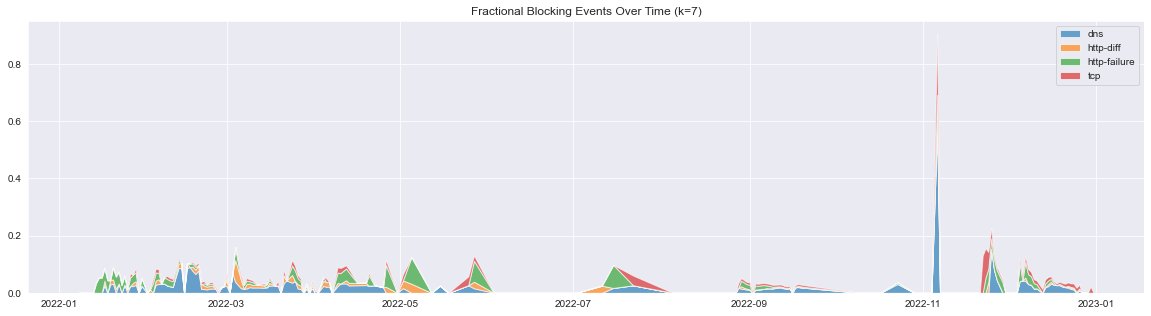

In [8]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-03-24-2022-04-18 (k=7)')

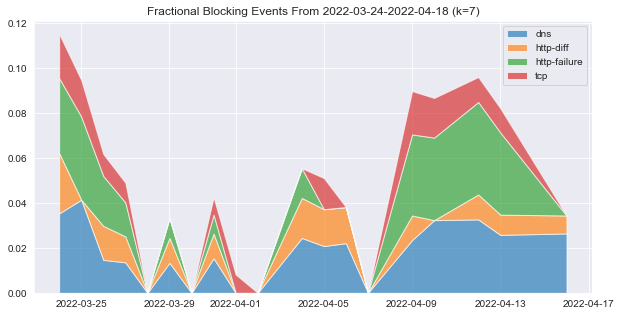

In [9]:
# Zoom in on a region of interest
start_date = '2022-03-24'
end_date = '2022-04-18'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [10]:
# Get blocking events in small date range
filter_tcp_range = (tcp_events.index >= start_date) & (tcp_events.index <= end_date)
filter_total_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
tcp_during = tcp_events[filter_tcp_range].groupby('input').size()
total_during = web_connectivity[filter_total_range].groupby('input').size()
frac_tcp_during = (tcp_during/total_during).fillna(0)
tcp_during.sort_values(ascending=False)
#print((tcp_during/total_during.sum()).sort_values(ascending=False)[:20])
tcp_out = tcp_events[~filter_tcp_range].groupby('input').size()
total_out = web_connectivity[~filter_total_range].groupby('input').size()
frac_tcp_out = (tcp_out/total_out).fillna(0)
#print((tcp_out/total_out.sum()).sort_values(ascending=False)[:20])
diff_frac_tcp = (frac_tcp_during-frac_tcp_out).sort_values(ascending=False).dropna()
diff_frac_tcp[:30]

input
i2p2.de/                          0.968750
gamenode.com/                     0.800000
0.39:9131/tor/server/authority    0.690299
mhut.org/                         0.666667
altpenis.com/                     0.380952
43things.com/                     0.346154
proxyweb.net/                     0.333333
blog.com/                         0.333333
rotten.com/                       0.333333
searx.me/                         0.250000
proxy.org/                        0.207143
iwhc.org/                         0.153846
sputniknews.com/                  0.137500
proxpn.com/                       0.116667
pi-dns.com/dns-query              0.045977
pastebin.com/                     0.000000
paltalk.com/                      0.000000
pdhre.org/                        0.000000
pcusa.org/                        0.000000
pcgamer.com/                      0.000000
pc2call.com/                      0.000000
panda.org/                        0.000000
pandora.com/                      0.000000
party

In [11]:
from statsmodels.stats.proportion import proportions_ztest

blocking_start = "2022-03-24"
blocking_end = "2022-04-18"

inner_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
outer_range = (web_connectivity.index < start_date) | (web_connectivity.index > end_date)
tcp_during = web_connectivity[inner_range].groupby('blocking').size()
tcp_outside = web_connectivity[outer_range].groupby('blocking').size()

successes = [tcp_during.sum() - tcp_during["False"], tcp_outside.sum() - tcp_outside["False"]]
sample_sizes = [tcp_during.sum(), tcp_outside.sum()]
print(successes)
print(sample_sizes)
z_stat, p_value = proportions_ztest(successes, sample_sizes)
print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")
print(successes[0] / sample_sizes[0])
print(successes[1] / sample_sizes[1])

[219, 2252]
[5359, 62322]
Z-Statistic: 1.7719365697695688
P-Value: 0.07640508706653867
0.040865833177831684
0.03613491223003113


In [12]:
import scipy.stats as stats

# Chi-square test of independence of variables
grouped_frame = pd.DataFrame({
    "during": tcp_during,
    "outside": tcp_outside
})
chi2, p_value, dof, expected = stats.chi2_contingency(grouped_frame.T)  # .T to transpose and get the correct format

# Step 3: Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 35.16113785012701
P-value: 4.3044229156607226e-07


In [13]:
tcp_blocked = tcp_events[filter_tcp_range].groupby('input').size()
print(len(tcp_blocked))
for i, j in tcp_during.items():
    print(str(i) + " " + str(j))

17
False 5140
dns 80
http-diff 37
http-failure 69
tcp_ip 33


Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

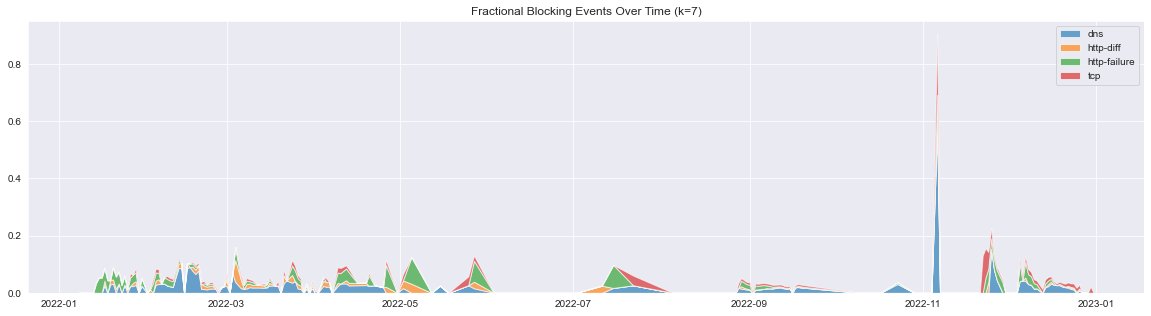

In [14]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

In [15]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn status_code_match  \
input                          date                                     
0.39:9131/tor/server/authority 2022-03-06  AS140989               NaN   
                               2022-03-24  AS140989               NaN   
                               2022-03-26  AS140989               NaN   
                               2022-03-31  AS140989               NaN   
                               2022-11-06   AS23752               NaN   
...                                             ...               ...   
yourvoyeurvideos.com/          2022-09-18   AS17501              True   
                               2022-12-16   AS17501              True   
youtube.com/                   2022-11-24   AS23752               NaN   
zoomshare.com/                 2022-02-23   AS45650               NaN   
zzn.com/                       2022-02-17   AS17501               NaN   

                                          resolver_asn  x_null_null_flags  \
input                          date                                         
0.39:9131/tor/server/authority 2022-03-06     AS140989                NaN   
                               2022-03-24     AS140989                NaN   
                               2022-03-26     AS140989                NaN   
                               2022-03-31     AS140989                NaN   
                               2022-11-06      AS23752                NaN   
...                                                ...                ...   
yourvoyeurvideos.com/          2022-09-18      AS17501                NaN   
                               2022-12-16      AS17501                NaN   
youtube.com/                   2022-11-24      AS23752                NaN   
zoomshare.com/                 2022-02-23      AS45170                NaN   
zzn.com/                       2022-02-17      AS17501                NaN   

                                          body_length_match dns_consistency  \
input                          date                                           
0.39:9131/tor/server/authority 2022-03-06               NaN      consistent   
                               2022-03-24               NaN      consistent   
                               2022-03-26               NaN      consistent   
                               2022-03-31               NaN      consistent   
                               2022-11-06               NaN      consistent   
...                                                     ...             ...   
yourvoyeurvideos.com/          2022-09-18             False    inconsistent   
                               2022-12-16             False    inconsistent   
youtube.com/                   2022-11-24               NaN      consistent   
zoomshare.com/                 2022-02-23               NaN      consistent   
zzn.com/                       2022-02-17               NaN    inconsistent   

                                          headers_match  \
input                          date                       
0.39:9131/tor/server/authority 2022-03-06           NaN   
                               2022-03-24           NaN   
                               2022-03-26           NaN   
                               2022-03-31           NaN   
                               2022-11-06           NaN   
...                                                 ...   
yourvoyeurvideos.com/          2022-09-18         False   
                               2022-12-16         False   
youtube.com/                   2022-11-24           NaN   
zoomshare.com/                 2022-02-23           NaN   
zzn.com/                       2022-02-17           NaN   

                                          dns_experiment_failure  \
input                          date                                
0.39:9131/tor/server/authority 2022-03-06                    NaN   
                               2022-03-24                    NaN   
                      

In [16]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
planetromeo.com/                67
206.212/tor/server/authority    67
gaytoday.com/                   52
pinkcupid.com/                  47
newnownext.com/                 46
                                ..
enom.com/                        1
naral.org/                       1
myspace.com/                     1
multiproxy.org/                  1
zzn.com/                         1
Length: 565, dtype: int64

In [17]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn status_code_match resolver_asn  \
input            date                                                  
planetromeo.com/ 2022-01-14   AS17501               NaN      AS17501   
                 2022-01-23   AS17501               NaN      AS17501   
                 2022-02-09   AS17501               NaN      AS17501   
                 2022-02-17   AS17501               NaN      AS17501   
                 2022-02-18   AS17501               NaN      AS17501   
...                               ...               ...          ...   
beeg.com/        2022-09-06   AS17501               NaN      AS17501   
                 2022-09-09   AS17501               NaN      AS17501   
                 2022-09-11   AS17501               NaN      AS17501   
                 2022-09-12   AS17501               NaN      AS17501   
                 2022-09-13   AS17501               NaN      AS17501   

                             x_null_null_flags body_length_match  \
input            date                                              
planetromeo.com/ 2022-01-14                NaN               NaN   
                 2022-01-23                NaN               NaN   
                 2022-02-09                NaN               NaN   
                 2022-02-17                NaN               NaN   
                 2022-02-18                NaN               NaN   
...                                        ...               ...   
beeg.com/        2022-09-06                NaN               NaN   
                 2022-09-09                NaN               NaN   
                 2022-09-11                NaN               NaN   
                 2022-09-12                NaN               NaN   
                 2022-09-13                NaN               NaN   

                            dns_consistency headers_match  \
input            date                                       
planetromeo.com/ 2022-01-14      consistent           NaN   
                 2022-01-23      consistent           NaN   
                 2022-02-09      consistent           NaN   
                 2022-02-17      consistent           NaN   
                 2022-02-18      consistent           NaN   
...                                     ...           ...   
beeg.com/        2022-09-06    inconsistent           NaN   
                 2022-09-09    inconsistent           NaN   
                 2022-09-11    inconsistent           NaN   
                 2022-09-12    inconsistent           NaN   
                 2022-09-13    inconsistent           NaN   

                            dns_experiment_failure http_experiment_failure  \
input            date                                                        
planetromeo.com/ 2022-01-14                    NaN               eof_error   
                 2022-01-23                    NaN               eof_error   
                 2022-02-09                    NaN               eof_error   
                 2022-02-17                    NaN               eof_error   
                 2022-02-18                    NaN               eof_error   
...                                            ...                     ...   
beeg.com/        2022-09-06                    NaN               eof_error   
                 2022-09-09                    NaN               eof_error   
                 2022-09-11                    NaN               eof_error   
                 2022-09-12                    NaN               eof_error   
                 2022-09-13                    NaN               eof_error   

                             body_proportion title_match      blocking  \
input            date                                                    
planetromeo.com/ 2022-01-14              0.0         NaN  http-failure   
                 2022-01-23              0.0         NaN  http-failure   
                 2022-02-09              0.0         NaN  http-failure   
                 2022-02-17

In [18]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,status_code_match,resolver_asn,x_null_null_flags,body_length_match,dns_consistency,headers_match,dns_experiment_failure,http_experiment_failure,body_proportion,title_match,blocking,accessible,x_dns_flags,control_failure,x_blocking_flags
date,,,,,,,,,,,,,,,,
2022-01-19,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.016873,False,dns,False,NaN,NaN,NaN
2022-01-27,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.016915,False,dns,False,NaN,NaN,NaN
2022-02-04,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.016914,False,dns,False,NaN,NaN,NaN
2022-02-12,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.020382,False,dns,False,NaN,NaN,NaN
2022-02-17,AS23752,True,AS23752,NaN,False,inconsistent,False,NaN,NaN,0.017607,False,dns,False,NaN,NaN,NaN
2022-02-23,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.019878,False,dns,False,NaN,NaN,NaN
2022-03-03,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.020126,False,dns,False,NaN,NaN,NaN
2022-03-12,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.020285,False,dns,False,NaN,NaN,NaN
2022-04-09,AS17501,True,AS17501,NaN,False,inconsistent,False,NaN,NaN,0.017370,False,dns,False,NaN,NaN,NaN


In [19]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,status_code_match,resolver_asn,x_null_null_flags,body_length_match,dns_consistency,headers_match,dns_experiment_failure,http_experiment_failure,body_proportion,title_match,blocking,accessible,x_dns_flags,control_failure,x_blocking_flags,input
date,,,,,,,,,,,,,,,,,
2022-01-06,AS17501,True,AS15169,NaN,True,consistent,True,NaN,NaN,1.0,True,False,True,NaN,NaN,NaN,planetromeo.com/
2022-01-14,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/
2022-01-23,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/
2022-02-01,AS17501,True,AS15169,NaN,True,consistent,True,NaN,NaN,1.0,True,False,True,NaN,NaN,NaN,planetromeo.com/
2022-02-09,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/
2022-12-23,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/
2022-12-23,AS17501,NaN,AS17501,NaN,NaN,consistent,NaN,NaN,eof_error,0.0,NaN,http-failure,False,NaN,NaN,NaN,planetromeo.com/


In [20]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [21]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [22]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [23]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.39:9131/tor/server/authority,0.000000,0.0,0.000000,0.098592
150m.com/,0.000000,0.0,0.038462,0.346154
163.com/,0.000000,0.0,0.071429,0.000000
164.118/tor/server/authority,0.000000,0.0,0.000000,0.015385
175.225/tor/server/authority,0.000000,0.0,0.000000,0.238095
...,...,...,...,...
youporn.com/,0.478261,0.0,0.130435,0.000000
yourvoyeurvideos.com/,0.375000,0.0,0.125000,0.000000
youtube.com/,0.000000,0.0,0.001294,0.000000


In [24]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
khilafah.net/,0.000000,0.888889,0.111111,0.000000
pornhib.com,0.000000,0.000000,1.000000,0.000000
matrimony.org/,0.000000,0.000000,0.000000,1.000000
terrorismfiles.org/,0.000000,1.000000,0.000000,0.000000
flirtylingerie.com/,0.000000,0.500000,0.500000,0.000000
...,...,...,...,...
mininova.org/,0.333333,0.000000,0.000000,0.000000
geocities.com/,0.000000,0.000000,0.333333,0.000000
gamenode.com/,0.000000,0.000000,0.000000,0.333333


In [25]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

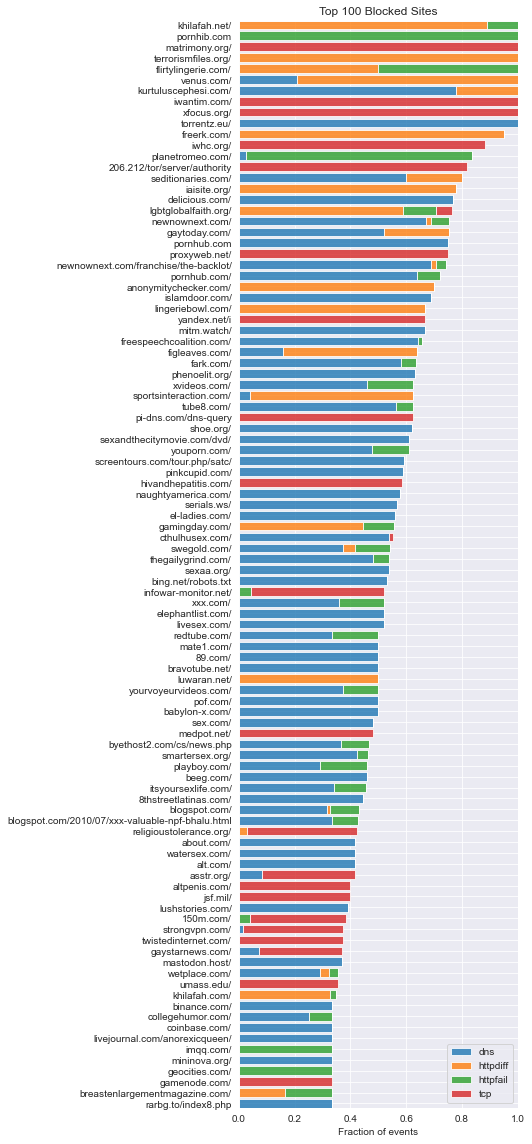

In [26]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')